In [1]:
import random as r
import pandas as pd
import seaborn as sns

In [2]:
payoff_matrix = [[(3,3), (0,4)], [(4,0), (1,1)]]  # 0: cooperate; 1: defect
# [first player strategy][second player strategy]
# (first player payoff, second player payoff)
strategies = ['C','T','D', 'O', 'R']
cmap = sns.cubehelix_palette(n_colors=3, as_cmap=True)
gridsize = 25

In [3]:
class Tournament():
  def __init__(self, payoff_matrix=None, strategies=None):
    self.payoff_matrix = payoff_matrix
    self.strategies = strategies
    self.population = []
    self.fitness_data = None

  def create_population(self, size, tat_frac=0, defect_frac=0): 
    self.population = []
    
    coop_frac = 1 - tat_frac - defect_frac
    self.population.extend([Agent(strategy='C') for _ in range(int(size*coop_frac))])
    self.population.extend([Agent(strategy='T') for _ in range(int(size*tat_frac))])
    self.population.extend([Agent(strategy='D') for _ in range(int(size*defect_frac))])


  def repeated_game(self, agent_1, agent_2, repititions):
    agent_2.last_opponents_strategy = 0
    agent_1.last_opponents_strategy = 0

    for _ in range(repititions):
      a1c = agent_1.act()
      a2c = agent_2.act()
      agent_2.last_opponents_strategy = a1c
      agent_1.last_opponents_strategy = a2c

      payoffs = self.payoff_matrix[a1c][a2c]

      agent_1.score += payoffs[0]
      agent_2.score += payoffs[1]

  def simulation_loop(self, iterations, depth=10):
    for i in range(iterations):
      self.repeated_game(r.choice(self.population), r.choice(self.population), depth)

    d = {'strategy': [a.strategy for a in self.population], 
         'score': [a.score for a in self.population]}
    self.fitness_data = pd.DataFrame(data=d)

  @property
  def reward_rates(self):
    assert self.fitness_data is not None
    counts = self.fitness_data.pivot(columns='strategy').count()
    sums = self.fitness_data.pivot(columns='strategy').fillna(0).sum()
    return sums/counts

In [4]:
class Agent():
  def __init__(self, strategy=None):
    self.strategy = strategy
    if strategy is None:
      self.strategy = r.choice(strategies)
    self.score = 0
    self.last_opponents_strategy = 0

  def act(self):
    strat = self.strategy
    if strat == 'C':  # cooperate
      return 0
    elif strat == 'D':  # defect
      return 1
    elif strat == 'T':  # tit-for-tat
      return self.last_opponents_strategy
    elif strat == 'O':  # opposite
      return (self.last_opponents_strategy+1) % 2
    elif strat == 'R':  # random
      return r.choice([0,1])

In [5]:
grid = [[0 for _ in range(gridsize)] for _ in range(gridsize)]
colorcode = {'C': 0, "T": 1, "D": 2}

for i in range(gridsize):
    for j in range(gridsize-i):
        a, b = i/gridsize, j/gridsize
        
        t = Tournament(payoff_matrix=payoff_matrix, strategies=strategies)
        t.create_population(120, a, b)
        t.simulation_loop(500, depth=20)
        
        key = t.reward_rates.sort_values(ascending=False).keys()[0][1] 
        value = colorcode[key]
        
        grid[i][j] = value

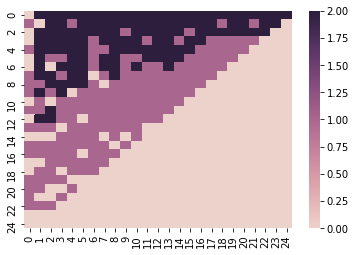

In [6]:
sns.heatmap(grid, cmap=cmap)